In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
sales_data = pd.read_excel('Data_Sample.xlsx')

In [3]:
sales_data.head()

,Product Name,Weight,Category,Month,Total Sell
0,"""XYZ"" Brand Turmeric Powder",25g,Basic Spices,2017-01,7423388.0
1,"""XYZ"" Brand Turmeric Powder",50g,Basic Spices,2017-01,7550634.0
2,"""XYZ"" Brand Turmeric Powder",100g,Basic Spices,2017-01,5304572.0
3,"""XYZ"" Brand Turmeric Powder",200g,Basic Spices,2017-01,3234489.0
4,"""XYZ"" Brand Turmeric Powder",400g,Basic Spices,2017-01,8204212.0


In [4]:
sales_data = sales_data.drop(["Product Name", "Weight", "Category"], axis=1)

In [5]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38520 entries, 0 to 38519
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       38520 non-null  object 
 1   Total Sell  38520 non-null  float64
dtypes: float64(1), object(1)
memory usage: 602.0+ KB


In [6]:
sales_data['Month'] = pd.to_datetime(sales_data['Month'])

In [7]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38520 entries, 0 to 38519
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       38520 non-null  datetime64[ns]
 1   Total Sell  38520 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 602.0 KB


In [8]:
monthly_sales = sales_data.groupby('Month').sum().reset_index()
monthly_sales = monthly_sales.set_index('Month')

In [9]:
monthly_sales.head()

,Total Sell
Month,
2017-01-01,3.423630e+09
2017-02-01,3.638747e+09
2017-03-01,3.530852e+09
2017-04-01,3.495955e+09
2017-05-01,3.558329e+09


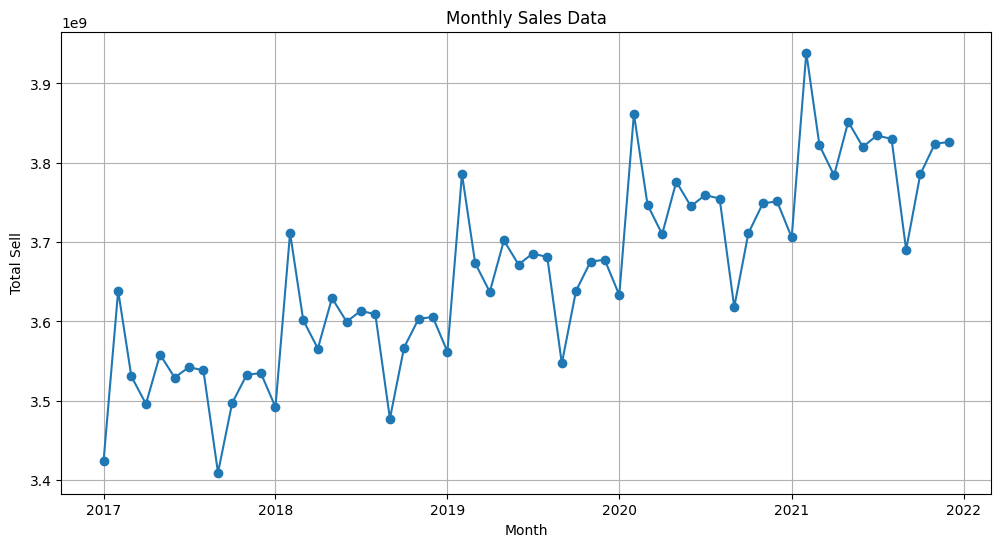

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['Total Sell'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Sell')
plt.title('Monthly Sales Data')
plt.grid(True)
plt.show()

ADF Testing

In [11]:
test_result = adfuller(monthly_sales['Total Sell'])

In [12]:
def adfuller_test(sales_data):
    result = adfuller(sales_data)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    if result[1] <= 0.05:
        print("Reject the null hypothesis, Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis, Data has unit root and it is non-stationary")

In [13]:
adfuller_test(monthly_sales['Total Sell'])

ADF Test Statistic : 3122873333466.6895
p-value : 1.0
#Lags Used : 11
Number of Observations Used : 48
Fail to reject the null hypothesis, Data has unit root and it is non-stationary


Differencing

In [14]:
monthly_sales['Total Sell_diff'] = monthly_sales['Total Sell'] - monthly_sales['Total Sell'].shift(12)

In [15]:
monthly_sales.head(14)

,Total Sell,Total Sell_diff
Month,,
2017-01-01,3.423630e+09,NaN
2017-02-01,3.638747e+09,NaN
2017-03-01,3.530852e+09,NaN
2017-04-01,3.495955e+09,NaN
2017-05-01,3.558329e+09,NaN
2017-06-01,3.529169e+09,NaN
2017-07-01,3.542399e+09,NaN
2017-08-01,3.538376e+09,NaN
2017-09-01,3.409333e+09,NaN


In [16]:
adfuller_test(monthly_sales['Total Sell_diff'].dropna())

ADF Test Statistic : -0.6130041269395914
p-value : 0.8680164698781578
#Lags Used : 8
Number of Observations Used : 39
Fail to reject the null hypothesis, Data has unit root and it is non-stationary


Again Differencing (As 1st Differencing failed to reject null hypothesis)

In [17]:
monthly_sales['Total Sell_diff'] = monthly_sales['Total Sell_diff'] - monthly_sales['Total Sell_diff'].shift(12)

In [18]:
monthly_sales.head(28)

,Total Sell,Total Sell_diff
Month,,
2017-01-01,3.423630e+09,NaN
2017-02-01,3.638747e+09,NaN
2017-03-01,3.530852e+09,NaN
2017-04-01,3.495955e+09,NaN
2017-05-01,3.558329e+09,NaN
2017-06-01,3.529169e+09,NaN
2017-07-01,3.542399e+09,NaN
2017-08-01,3.538376e+09,NaN
2017-09-01,3.409333e+09,NaN


In [19]:
adfuller_test(monthly_sales['Total Sell_diff'].dropna())

ADF Test Statistic : -4.144967717333676
p-value : 0.0008154109516353047
#Lags Used : 0
Number of Observations Used : 35
Reject the null hypothesis, Data has no unit root and is stationary


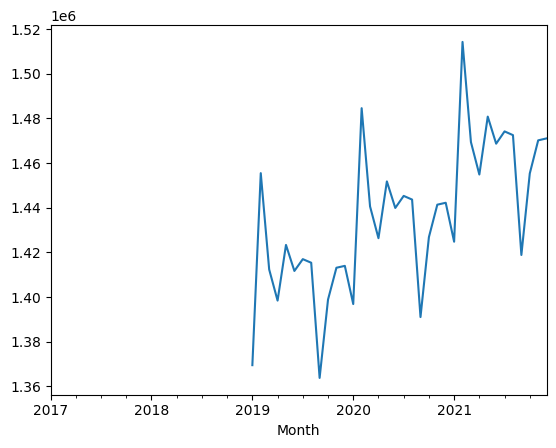

In [20]:
monthly_sales['Total Sell_diff'].plot()
plt.show()

Finding ACF, PACF

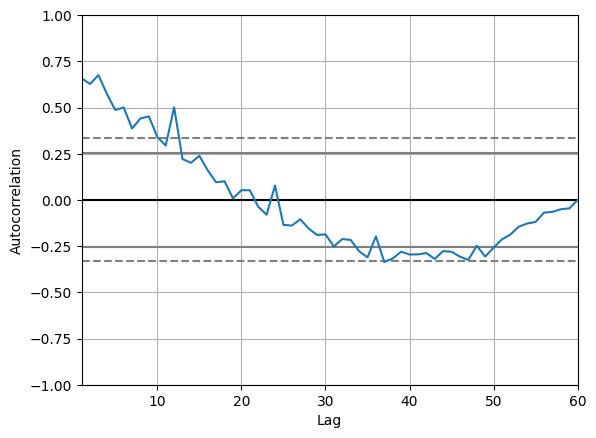

In [21]:
autocorrelation_plot(monthly_sales['Total Sell'])
plt.show()

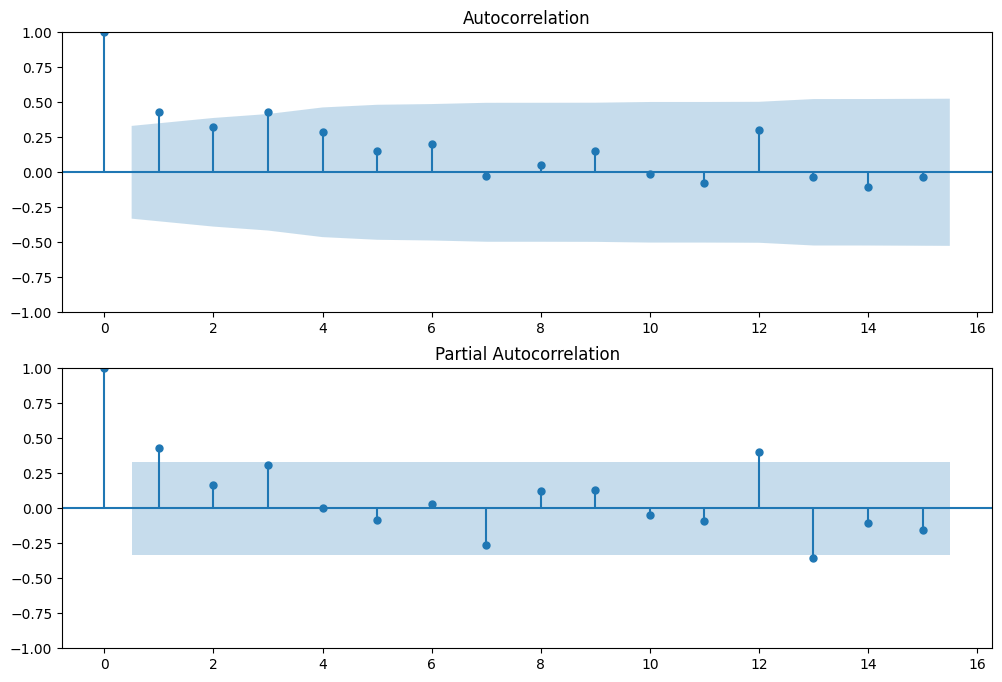

In [22]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_sales['Total Sell_diff'].iloc[25:], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_sales['Total Sell_diff'].iloc[25:], lags=15, ax=ax2)

Splitting and Testing data

In [23]:
data = pd.read_excel('Data_Sample.xlsx', index_col='Month', parse_dates=True)
data = data['Total Sell']

In [24]:
# Split the monthly_sales data, which was used to fit the SARIMAX model
train = monthly_sales['Total Sell'][:-12]
test = monthly_sales['Total Sell'][-12:]

Fit SARIMA model

In [25]:
#Model A:(1,1,1)(1,1,1,12)
model_a = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_a = model_a.fit()

forecast_a = results_a.get_forecast(steps=12)

#Model B:(1,2,1)(1,2,1,12)
model_b = SARIMAX(train, order=(1, 2, 1), seasonal_order=(1, 2, 1, 12))
results_b = model_b.fit()

forecast_b = results_b.get_forecast(steps=12)

#Model C:(1,2,1)(0,1,0,12)
model_c = SARIMAX(train, order=(1, 2, 1), seasonal_order=(0, 1, 0, 12))
results_c = model_b.fit()

forecast_c = results_c.get_forecast(steps=12)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No freq

In [26]:
def evaluate_forecast(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mse, rmse, mae, mape

Comparing Models

In [27]:
rmse_a, mse_a, mae_a, mape_a = evaluate_forecast(test, forecast_a.predicted_mean)
print("Model A:")
print("RMSE:", rmse_a)
print("MAE:", mae_a)
print("MAPE:", mape_a)

rmse_b, mse_b, mae_b, mape_b = evaluate_forecast(test, forecast_b.predicted_mean)
print("\nModel B:")
print("RMSE:", rmse_b)
print("MAE:", mae_b)
print("MAPE:", mape_b)

rmse_c, mse_c, mae_c, mape_c = evaluate_forecast(test, forecast_c.predicted_mean)
print("\nModel C:")
print("RMSE:", rmse_c)
print("MAE:", mae_c)
print("MAPE:", mape_c)

Model A:
RMSE: 2791392604040.3457
MAE: 1488691.036306262
MAPE: 0.03883927007414237

Model B:
RMSE: 18817880661.15447
MAE: 102448.17141254742
MAPE: 0.002692946469427585

Model C:
RMSE: 18817880661.15447
MAE: 102448.17141254742
MAPE: 0.002692946469427585


Visualization

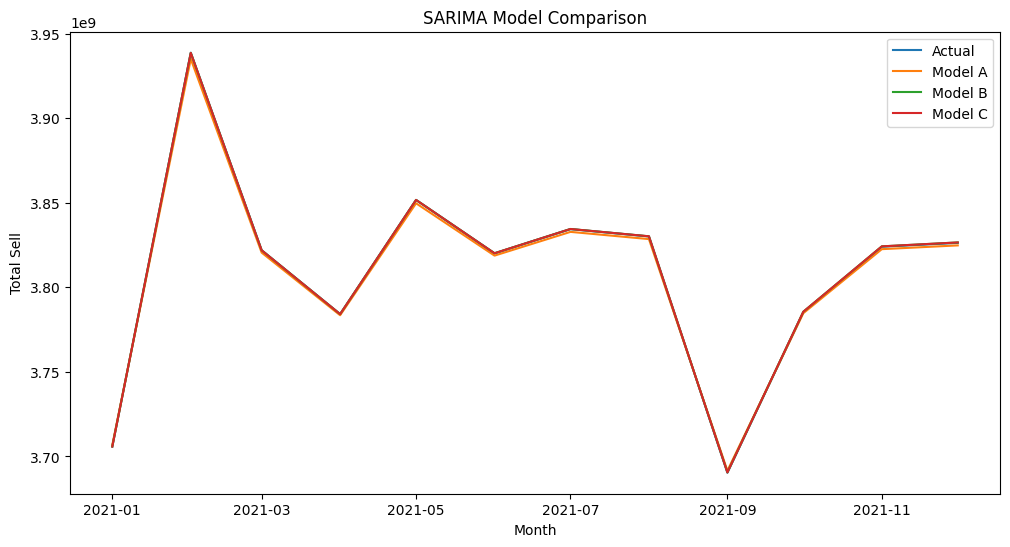

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(forecast_a.predicted_mean.index, forecast_a.predicted_mean.values, label='Model A')
plt.plot(forecast_b.predicted_mean.index, forecast_b.predicted_mean.values, label='Model B')
plt.plot(forecast_c.predicted_mean.index, forecast_c.predicted_mean.values, label='Model C')
plt.xlabel('Month')
plt.ylabel('Total Sell')
plt.title('SARIMA Model Comparison')
plt.legend()
plt.show()

Ljung_Box Statistical Residual Test

In [29]:
ljung_box_results = acorr_ljungbox(results_a.resid, lags=[10], return_df=True)
print(ljung_box_results)

ljung_box_results = acorr_ljungbox(results_b.resid, lags=[10], return_df=True)
print(ljung_box_results)

ljung_box_results = acorr_ljungbox(results_c.resid, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  0.211012        1.0
     lb_stat  lb_pvalue
10  11.77882   0.300132
     lb_stat  lb_pvalue
10  11.77882   0.300132


SARIMAX Model

In [30]:
model = sm.tsa.statespace.SARIMAX(monthly_sales['Total Sell'], order=(1, 2, 1), seasonal_order=(1, 2, 1, 12))
results = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [31]:
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Total Sell   No. Observations:                   60
Model:             SARIMAX(1, 2, 1)x(1, 2, 1, 12)   Log Likelihood                -425.263
Date:                            Fri, 03 Oct 2025   AIC                            860.525
Time:                                    22:47:51   BIC                            868.157
Sample:                                01-01-2017   HQIC                           863.128
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0868      0.581     -0.149      0.881      -1.226       1.053
ma.L1          0.0868      0.581      0.149      0.881      -1.052       1.226
ar.S.L12       0.0042      0.178      0.024      0.981      -0.345       0.353
ma.S.L12      -0.0042      0.178     -0.024      0.981      -0.353       0.345
sigma2      1.255e+09    3.7e-10    3.4e+18      0.000    1.25e+09    1.25e+09
===================================================================================
Ljung-Box (L1) (Q):                   9.60   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.00   Prob(JB):                         0.46
Heteroskedasticity (H):               3.00   Skew:                            -0.39
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.55e+35. Standard errors may be unstable.
"""

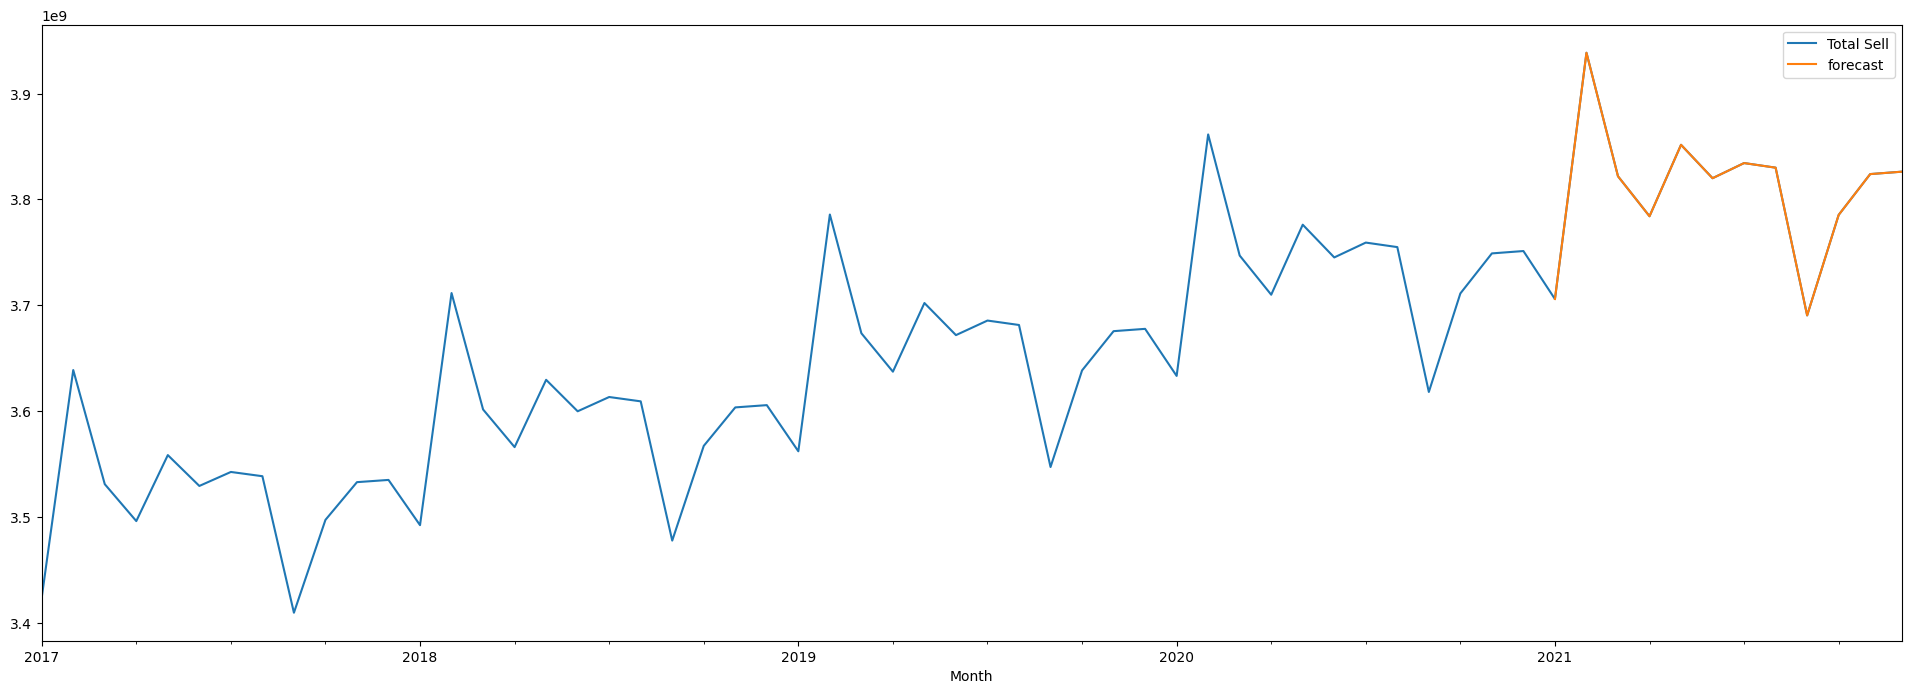

In [32]:
monthly_sales['forecast'] = results.predict(start='2021-01-01', end='2021-12-01', dynamic=True)
monthly_sales[['Total Sell', 'forecast']].plot(figsize=(24, 8))
plt.show()

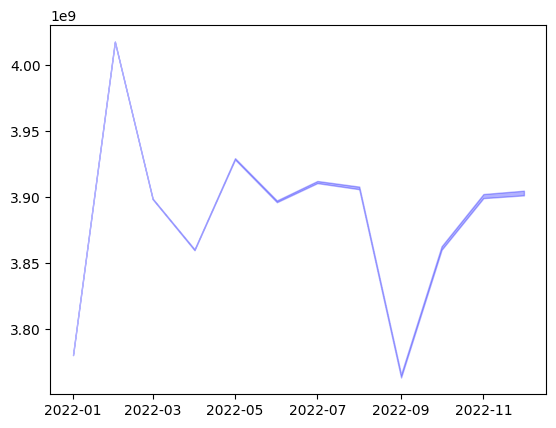

In [33]:
forecast = results.get_forecast(steps=12)
conf_int = forecast.conf_int()

plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='b', alpha=0.3)

In [34]:
future_dataset = [monthly_sales.index[-1] + DateOffset(months=x) for x in range(1, 13)]
future_dataset_df = pd.DataFrame(index=future_dataset[1:], columns=monthly_sales.columns)

In [35]:
future_dataset = pd.concat([monthly_sales, future_dataset_df])

/tmp/ipython-input-292022111.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_dataset = pd.concat([monthly_sales, future_dataset_df])


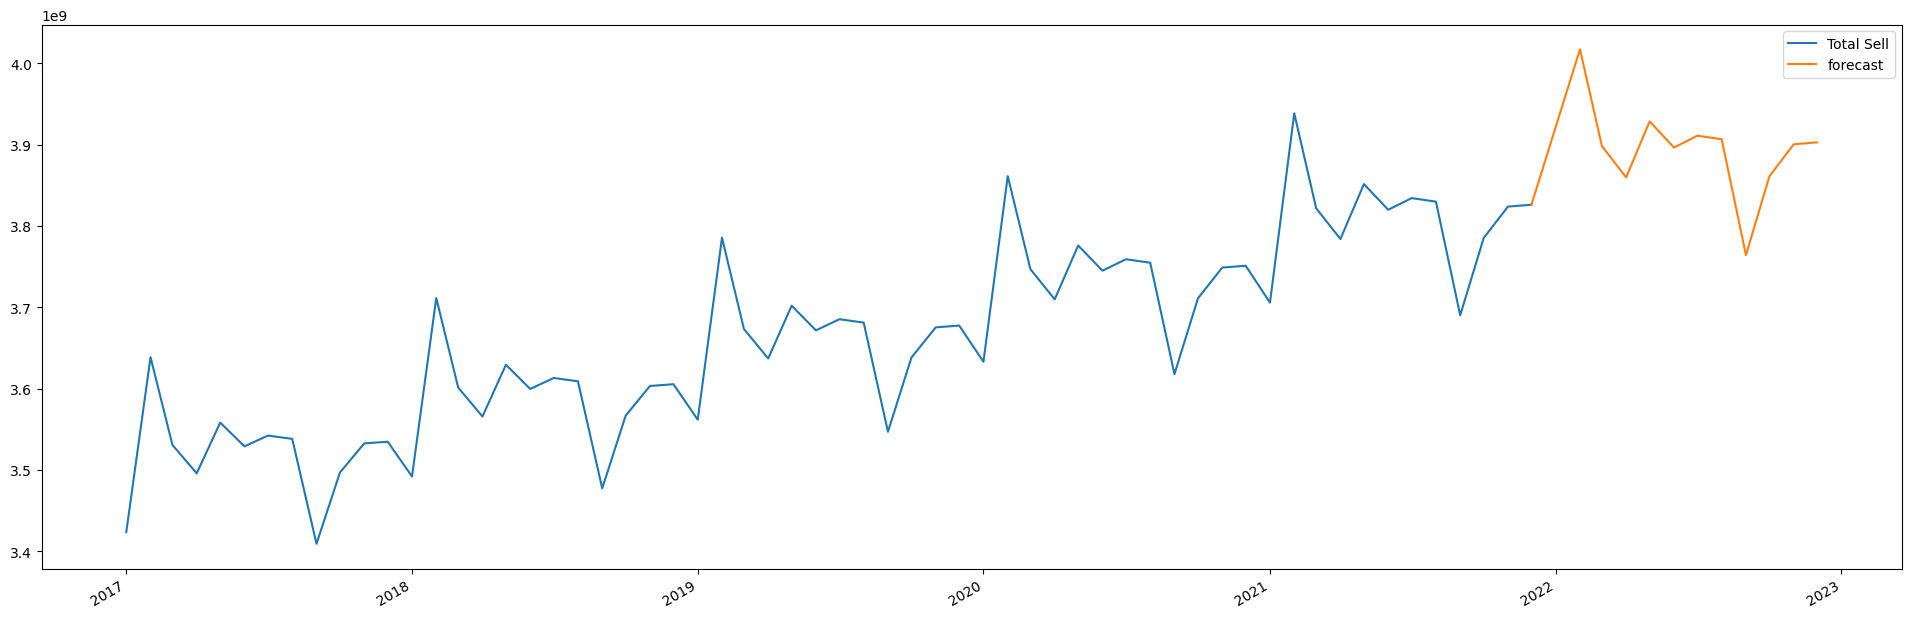

In [36]:
future_dataset['forecast'] = results.predict(start='2021-12-01', end='2022-12-01', dynamic=True)
future_dataset[['Total Sell', 'forecast']].plot(figsize=(24, 8))
plt.show()